# Coding project

> The coding project (alternatively, “dissertation” or “capstone project”) is a major piece of written work
that concludes a graduate degree study programme. This does not mean however that you would be 
required to write a dissertation identical to the written piece of work to be submitted by students on 
the other MSc programmes. In effect, instead of a classic theory-based dissertation, the purpose of the 
Coding Project should rather be to test your ability to resolve a problem with data analysis and data 
science tools based on relevant input data, with the output of the project including the relevant codes, 
their explanation, and a reflective account on how you completed the project.

 ## Task description

 The project will be based on the regular lab-like practice assignments in MIB Data Analytics 1-2 and MIB Big Data and Machine Learning, but will necessitate the incorporation of multiple solutions and considerations relating to data pipelines. Like in real life data science project, you need to use tools, pipelines which we interiorized previous courses. From analysing through classical machine learning models until deep learning models, you need to use these tools, for analysing and prediction. 


The task is open ended, which means that, e.g., it's up to you decide which variables you use and how, of course, and how you encode them, what models to use, etc.

Please make sure to at least browse through the Coding Project Handbook (on Moodle). You will see that you are required to not simply do the modelling, but reflect on the steps you take and the results you get, and ideally not just on the final performance.

## Dataset


You have the choice to work on **either the dataset and task provided** (soil moisture modelling), **or on data from and task for a company** you are working for.

If you choose to work on a company project, please make sure to clarify with your company if they need a confidentiality agreement (there is a sample on the Moodle page, but you can use your company's own NDA, instead, ofcourse), and get consent to use it in your project (you can find a template for a letter of confirmation and consent in Appendix 1 of the Coding Project Handbook on Moodle).

> Important: You DON'T have to upload any data to Moodle or anywhere. You only have to submit the thesis (and your .ipynb).




### Modeling soil moisture

Task: to predict **soil moisture values (variable BF10) 30 days ahead**.

> Clarification: this means that you have to forecast ONE value for each sample, and that is for the day that is 30 days down the line. E.g., for 7th April, you would be making a forecast for the 7th May.


[Soil and weather variables in the German city of Münster](https://drive.google.com/uc?export=download&id=173tvWt-qPyAqZJc1KoBiUHgoSg6nLUtT)

*(Data source: [DWD](https://www.dwd.de/EN/ourservices/cdc/cdc_ueberblick-klimadaten_en.html))*

* TT_TER and RF_TER variables are measured three times a day.
* VGSL, TS05, BF10 are calculated once a day. The daily values are filled into each hour of the relevant day in the .csv datafile.

Make sure to go through all the steps of a modelling process, documenting and supporting the steps you take.

### Columns of the dataset:

**DATUM**: The datetime column

**STATIONS_ID**	DWD weather station ID
  * 1766 = Münster/Osnabrück

**QN_4**: quality level of TT_TER and RF_TER columns
  * 1- only formal control during decoding and import
  * 2- controlled with individually defined criteria
  * 3- ROUTINE control with QUALIMET and QCSY
  * 5- historic, subjective procedures
  * 7- ROUTINE control, not yet corrected
  * 8- quality control outside ROUTINE
  * 9- ROUTINE control, not all parameters corrected
  * 10- ROUTINE control finished, respective corrections finished

**TT_TER**: air temperature

**RF_TER**: relative humidty

**VGSL**: real evapotranspiration over gras and sandy loam (mm)

**TS05**: mean daily soil temperature in 5 cm depth for uncovered typical soil (°C)

**BF10**: soil moisture under
grass and sandy loam
between 0 and 10 cm
depth in % plant useable
water (%nFK)

## Formal requirements
Formal requirements and other informations are available on Moodle in the "Coding Project Handbook".


## Data downloading

In [ ]:
!wget https://drive.google.com/uc?export=download&id=173tvWt-qPyAqZJc1KoBiUHgoSg6nLUtT

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

In [73]:
# Generate a seed for reproductibility
random_seed = 69420
np.random.seed(random_seed)

df = pd.read_csv('munster_hourly.csv', parse_dates=["DATUM"])
# df.set_index("DATUM", inplace=True)
# Drop any NaN values
df.dropna(inplace=True)
df

,DATUM,STATIONS_ID,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10
0,1991-01-01 07:00:00,1766,10,3.0,91.0,0.3,2.9,102
1,1991-01-01 14:00:00,1766,10,4.8,85.0,0.3,2.9,102
2,1991-01-01 21:00:00,1766,10,3.9,82.0,0.3,2.9,102
3,1991-01-02 07:00:00,1766,10,5.6,94.0,1.4,6.3,110
4,1991-01-02 14:00:00,1766,10,11.0,87.0,1.4,6.3,110
...,...,...,...,...,...,...,...,...
35667,2021-12-30 00:00:00,1766,1,11.6,90.0,0.8,9.4,104
35668,2021-12-30 06:00:00,1766,1,11.1,98.0,0.8,9.4,104
35669,2021-12-30 12:00:00,1766,1,14.3,83.0,0.8,9.4,104
35670,2021-12-30 18:00:00,1766,1,13.5,90.0,0.8,9.4,104


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATUM        35672 non-null  datetime64[ns]
 1   STATIONS_ID  35672 non-null  int64         
 2   QN_4         35672 non-null  int64         
 3   TT_TER       35672 non-null  float64       
 4   RF_TER       35672 non-null  float64       
 5   VGSL         35672 non-null  float64       
 6   TS05         35672 non-null  float64       
 7   BF10         35672 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 2.2 MB


In [ ]:
reindexed_df = df.copy()
reindexed_df.DATUM = reindexed_df.DATUM.astype('datetime64[ns]')
reindexed_df = reindexed_df.set_index("DATUM")

reindexed_df

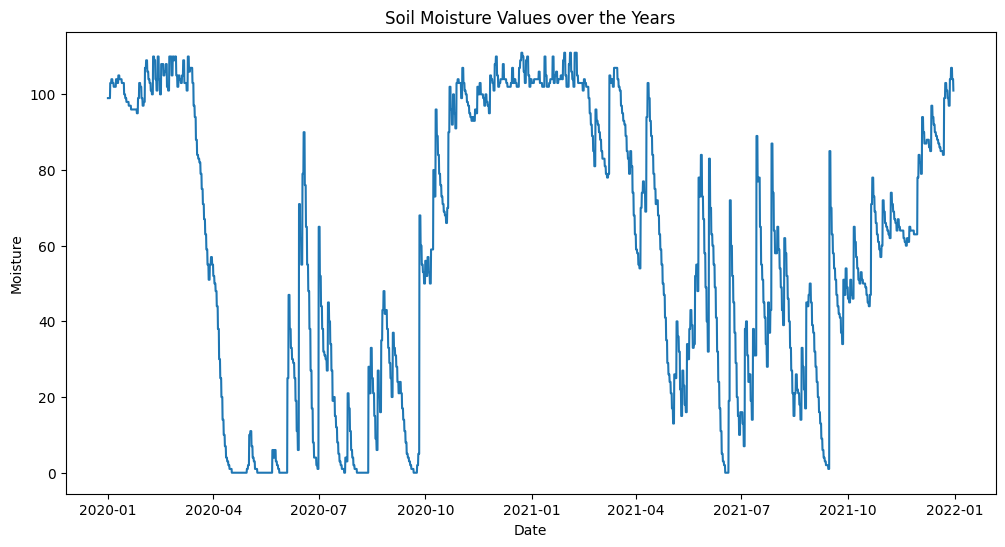

In [88]:
plt.figure(figsize=(12,6))
plt.title('Soil Moisture Values over the Years')
plt.xlabel('Date')
plt.ylabel('Moisture')
plt.plot(reindexed_df['BF10']['2020-01-01':])

/tmp/ipykernel_1774/3907930191.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)


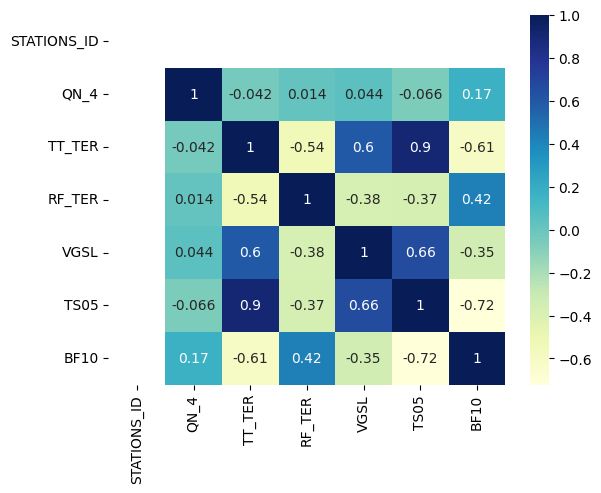

In [89]:
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

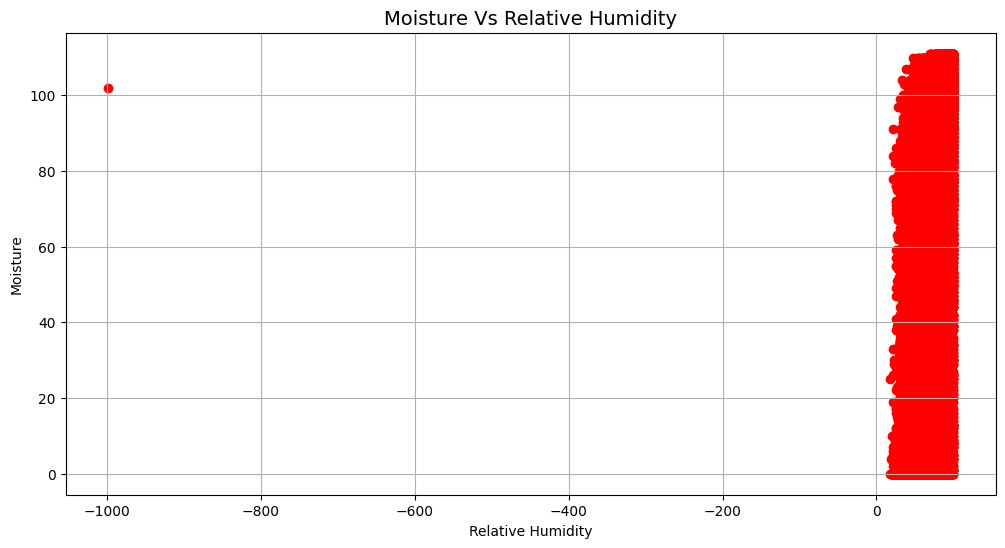

In [90]:
plt.figure(figsize=(12,6))
plt.scatter(df['RF_TER'], df['BF10'], color='red')
plt.title('Moisture Vs Relative Humidity', fontsize=14)
plt.xlabel('Relative Humidity')
plt.ylabel('Moisture')
plt.grid(True)
plt.show()

In [91]:
df.drop(df[df.RF_TER < -1].index, inplace=True)

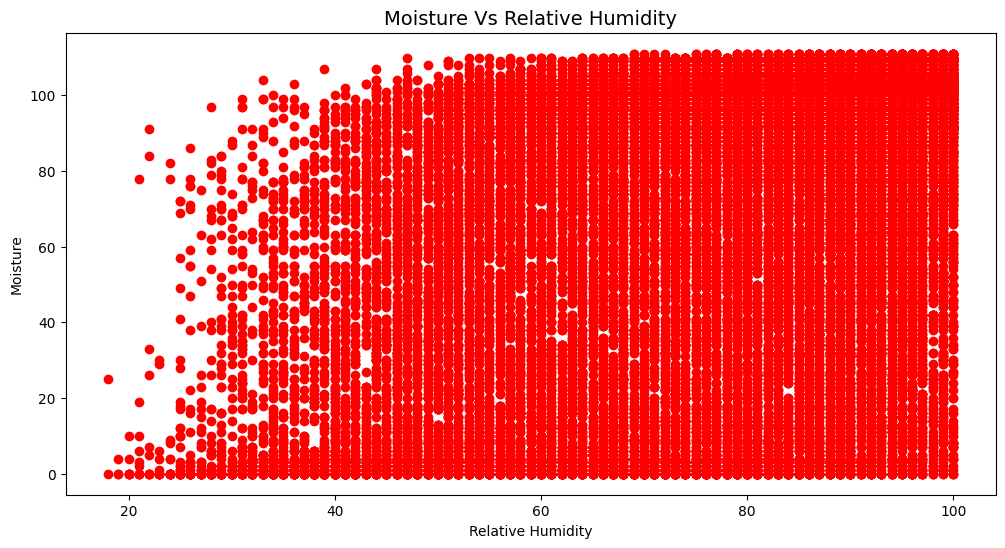

In [92]:
plt.figure(figsize=(12,6))
plt.scatter(df['RF_TER'], df['BF10'], color='red')
plt.title('Moisture Vs Relative Humidity', fontsize=14)
plt.xlabel('Relative Humidity')
plt.ylabel('Moisture')
plt.show()

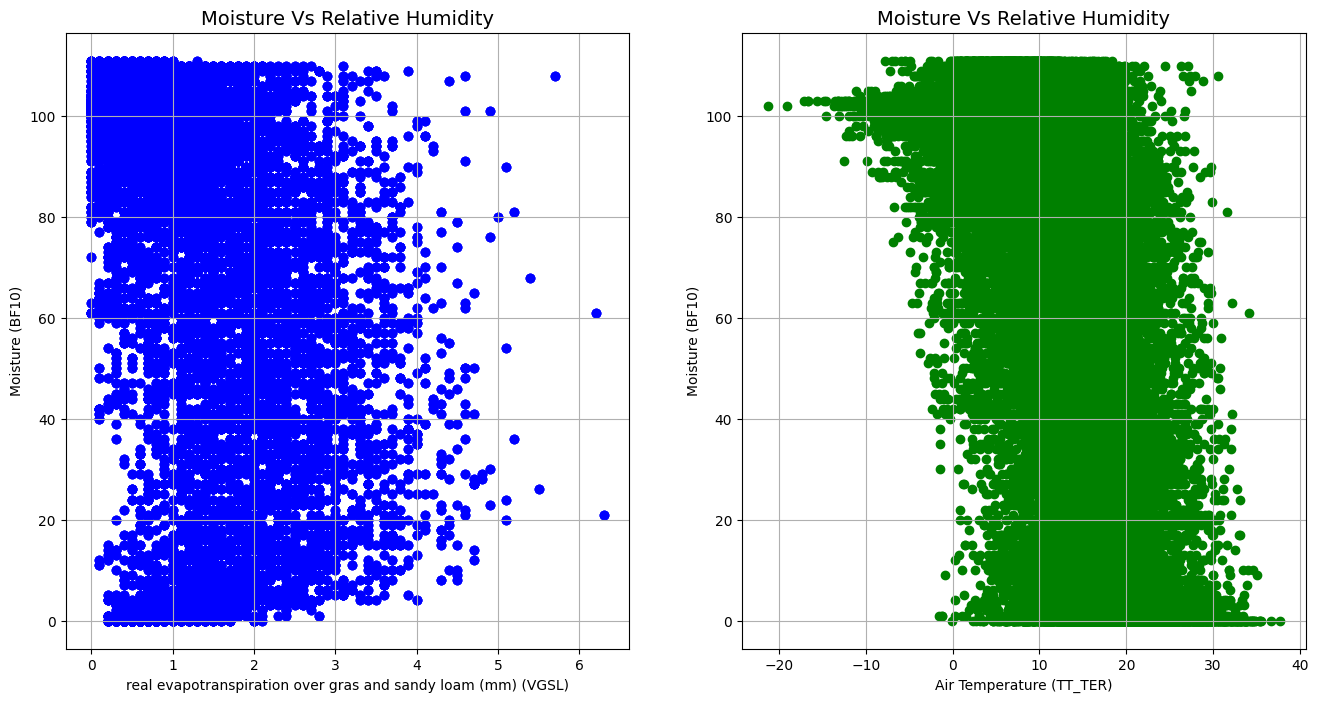

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.set_title('Moisture Vs Relative Humidity', fontsize=14)
ax1.set_xlabel('real evapotranspiration over gras and sandy loam (mm) (VGSL)')
ax1.set_ylabel('Moisture (BF10)')
ax1.scatter(df['VGSL'], df['BF10'], color='blue')
ax1.grid(True)

ax2.set_title('Moisture Vs Relative Humidity', fontsize=14)
ax2.set_xlabel('Air Temperature (TT_TER)')
ax2.set_ylabel('Moisture (BF10)')
ax2.scatter(df['TT_TER'], df['BF10'], color='green')
ax2.grid(True)

plt.show()

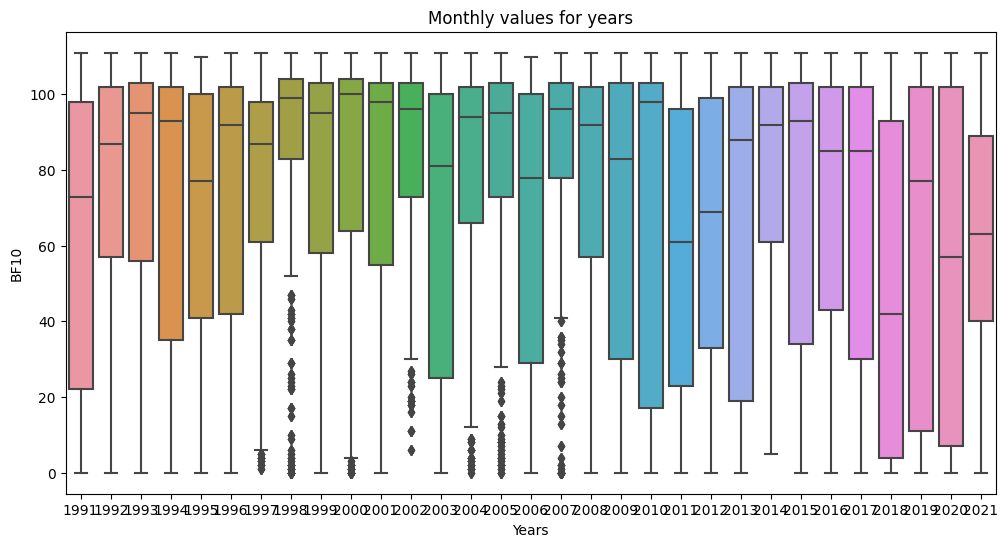

In [94]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x=reindexed_df.index.year, y=reindexed_df["BF10"])#, width=20)
plt.title("Monthly values for years")
plt.xlabel("Years")
plt.show()

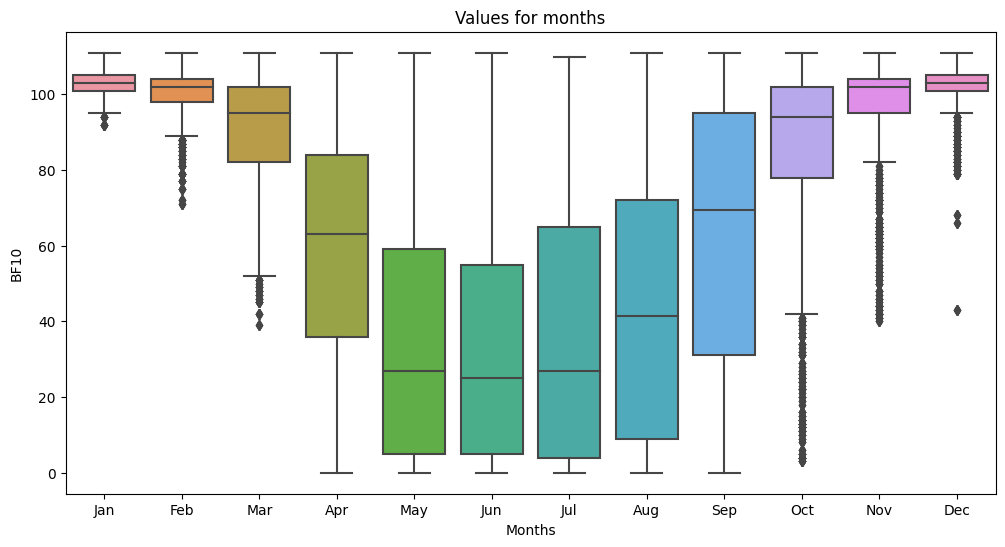

In [96]:
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(x=reindexed_df.index.strftime("%b"), y=reindexed_df["BF10"], ax=ax)
plt.title("Values for months")
plt.xlabel("Months")
plt.show()

In [101]:
# Dropping columns we won't be using for the predictions of closing price
X = []

# Getting just the closing price column
y = []

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.2, random_state=random_seed)

print("", X_train.shape, "\n", y_train.shape,
      "\n", X_test.shape, "\n", y_test.shape)

 (28537,) 
 (28537,) 
 (7135,) 
 (7135,)


In [102]:
# Fitting the linear regression model with the training data
linear = LinearRegression().fit(X_train,y_train)

# Making predictions using the testing data
predicted_lr = linear.predict(X_test)

# Plotting the predicted values
plt.plot(predicted_lr, color='orange')
plt.ylabel('Predicted Moisture Levels')
plt.xlabel('# of Days')
plt.title('Linear Regression Model')
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[ 91.  85.  82. ...  83. 100.  98.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.